In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cdd

import plotly.graph_objects as go
from scipy.spatial import ConvexHull

In [4]:
#V = np.array([[-1,0,1,1,-1], [0,1,-1,-1,1], [0,-3,-1,1,0], [-1,0,0,-1,0], [-1,1,-1,-1,1], [0,-1,1,1,0], [0,0,0,-1,0]])
#V = np.array([[-2,0,1,0,-1], [1,0,1,-1,2], [-1,1,-1,-2,0], [1,-1,0,2,0], [1,0,0,-1,0], [0,0,0,2,-1]])

#V = np.array([[-2, 3, 1, -3, 0], [1, -2, -1, 2, 0], [4, -4, 1,  2, -2], [1, 2, 3, 0, -1], [-3, 3, -1, -2, 2], [1, 2, 3, -3, -1], [-2, -1, -3, 0, 2]])
#V = np.array([[4, -2, 3, 2, -3], [1, -2, -1, 2, 0], [4, -4, 1, 2, -2], [1, 2, 3, 0, -1], [-3, 3, -1, -2, 2], [1, 2, 3, -3, -1], [-2, -4, -5, 2, 1]])

V = np.array([[  0,   0,   0,   1,   1],
 [  1,   0,   0,  -2,  -2],
 [  0,   0,   0,   1,   1],
 [  0,  -2,   0,   1,  -1],
 [ -5,   3,  -1,   1,  -4],
 [  1,   0,   0,  -1,   0],
 [  0,  -1,   1,   1,   3],
 [  6,  -1,   1,  -5,   1],
 [-12,   2,  -2,   7,  -7]])



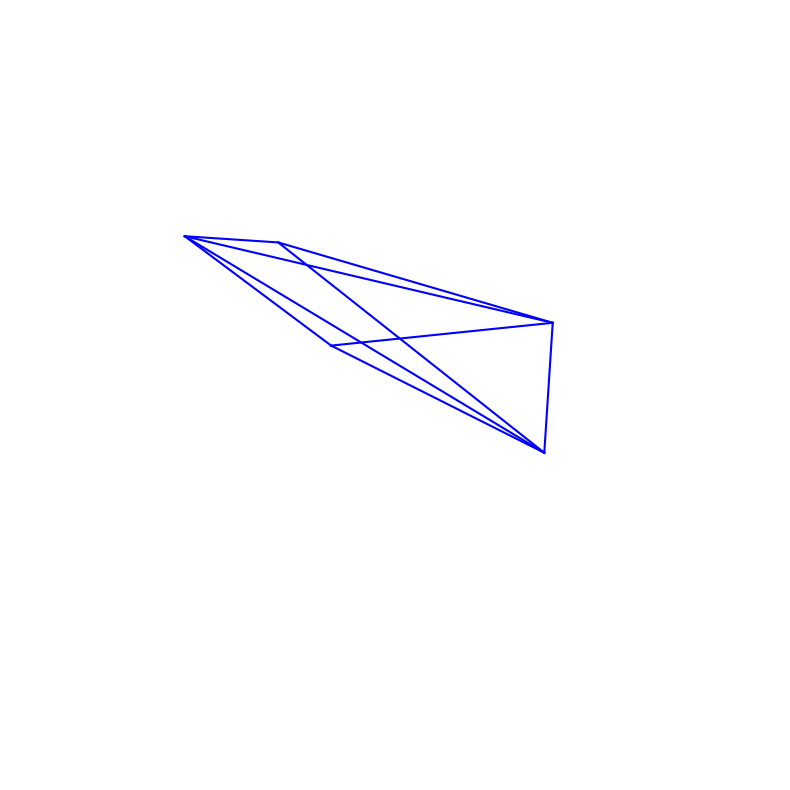

In [5]:
#project the 5D polyhedron to 3D
#see: https://math.stackexchange.com/questions/2677864/how-to-project-5d-to-3d
#and: https://stackoverflow.com/questions/13548241/python-numpy-optimization-n-dimensional-projection
def nsphere(mat, littleD=3):
    projected_mat = np.empty([0, 3])
    for a in mat:
        a = a / np.sqrt(np.dot(a, a))
        z = a[littleD:].sum()
        projected_mat = np.append(projected_mat, np.array([a[:littleD] / (1. - z)]), axis=0)
    return projected_mat

V = nsphere(V)

# to get the convex hull with cdd, one has to prepend a column of ones
num_verts = V.shape[0]
vertices = np.hstack((np.ones((num_verts,1)), V))

# construct the polyhedron
mat = cdd.Matrix(vertices, linear=False, number_type="float") 
mat.rep_type = cdd.RepType.GENERATOR
poly = cdd.Polyhedron(mat)

# get the adjacent vertices of each vertex
adjacencies = [list(x) for x in poly.get_input_adjacency()]

# store the edges in a matrix (giving the indices of the points)
edges = [None]*(num_verts-1)
for i,indices in enumerate(adjacencies[:-1]):
    indices = list(filter(lambda x: x>i, indices))
    l = len(indices)
    col1 = np.full((l, 1), i)
    indices = np.reshape(indices, (l, 1))
    edges[i] = np.hstack((col1, indices))
Edges = np.vstack(tuple(edges)).astype(int)

num_edges = Edges.shape[0]

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

start = V[Edges[:,0]]
end = V[Edges[:,1]]

for i in range(num_edges):
    ax.plot(
        [start[i,0], end[i,0]], 
        [start[i,1], end[i,1]], 
        [start[i,2], end[i,2]],
        "blue"
    )

plt.axis('off')
plt.show()

In [4]:
#project the 5D polyhedron to 3D
#see: https://math.stackexchange.com/questions/2677864/how-to-project-5d-to-3d
#and: https://stackoverflow.com/questions/13548241/python-numpy-optimization-n-dimensional-projection
def nsphere(mat, littleD=3):
    projected_mat = np.empty([0, 3])
    for a in mat:
        a = a / np.sqrt(np.dot(a, a))
        z = a[littleD:].sum()
        projected_mat = np.append(projected_mat, np.array([a[:littleD] / (1. - z)]), axis=0)
    return projected_mat

V = nsphere(V)

hull = ConvexHull(V)
hull_points = hull.points
hull_simplices = hull.simplices

x = hull_points[:, 0]
y = hull_points[:, 1]
z = hull_points[:, 2]

i = hull_simplices[:, 0]
j = hull_simplices[:, 1]
k = hull_simplices[:, 2]

mesh3d  = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=1.0, flatshading=True, color="#ce6a6b")
layout = go.Layout(width=600, height=600, title_text='polytope', title_x=0.5)
fig = go.Figure(data=[mesh3d], layout=layout)
fig.layout.scene.update(xaxis_showticklabels=False, xaxis_ticks='', xaxis_title='',
                        yaxis_showticklabels=False, yaxis_ticks='',yaxis_title='',
                        zaxis_showticklabels=False, zaxis_ticks='', zaxis_title='')
fig.data[0].update(lighting=dict(ambient=0.5, diffuse=1, fresnel=4, specular=0.5, roughness=0.5))

fig.show()